In [1]:
# importing libraries
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for model building
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
# READ DATA
train_df = pd.read_csv("./train_BRCpofr.csv", index_col='id')

In [3]:
# view
train_df.head()

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
id,,,,,,,,,,,
1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


In [4]:
# Shape of dataset
print("Number of rows::".ljust(20), train_df.shape[0])
print("Number of columns::".ljust(20), train_df.shape[1])

Number of rows::     89392
Number of columns::  11


In [5]:
# Column names
print("Column list::", train_df.columns.tolist())

Column list:: ['gender', 'area', 'qualification', 'income', 'marital_status', 'vintage', 'claim_amount', 'num_policies', 'policy', 'type_of_policy', 'cltv']


In [6]:
# Check if there is any duplicate records present in data
train_df.duplicated().sum()

26

In [7]:
# Drop the duplicates
train_df = train_df.drop_duplicates(ignore_index=True)

In [8]:
# Summary statistics 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89366 entries, 0 to 89365
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          89366 non-null  object
 1   area            89366 non-null  object
 2   qualification   89366 non-null  object
 3   income          89366 non-null  object
 4   marital_status  89366 non-null  int64 
 5   vintage         89366 non-null  int64 
 6   claim_amount    89366 non-null  int64 
 7   num_policies    89366 non-null  object
 8   policy          89366 non-null  object
 9   type_of_policy  89366 non-null  object
 10  cltv            89366 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 7.5+ MB


The above training dataset has total 89366 of rows and 10 columns. The name of columns names seems perfect and does not contain any null values. The all data column types appear to be categorical except claim_amount and cltv.

In [9]:
# Check unique values in categorical data.
categorical_columns = train_df.drop(columns=['claim_amount', 'cltv'], axis=1).columns.tolist()
for col in categorical_columns:
    print(f"{col.upper().ljust(18)}:{train_df[col].unique()}")

GENDER            :['Male' 'Female']
AREA              :['Urban' 'Rural']
QUALIFICATION     :['Bachelor' 'High School' 'Others']
INCOME            :['5L-10L' 'More than 10L' '2L-5L' '<=2L']
MARITAL_STATUS    :[1 0]
VINTAGE           :[5 8 7 6 1 0 3 4 2]
NUM_POLICIES      :['More than 1' '1']
POLICY            :['A' 'C' 'B']
TYPE_OF_POLICY    :['Platinum' 'Gold' 'Silver']


## Split the data

In [10]:
# Further split the data into training, validation and test datasets in ratio of 70:20:10.
df_full, df_test = train_test_split(train_df, test_size=10, random_state=42)
df_train, df_valid = train_test_split(df_full, test_size=18, random_state=42)

In [11]:
# Split the data into X and y
X_train = df_train.drop(['cltv'], axis=1)
y_train = df_train['cltv']

X_valid = df_valid.drop(['cltv'], axis=1)
y_valid = df_valid['cltv']

X_test = df_test.drop(['cltv'], axis=1)
y_test = df_test['cltv']

In [12]:
# Reindexing
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

# Data Analysis

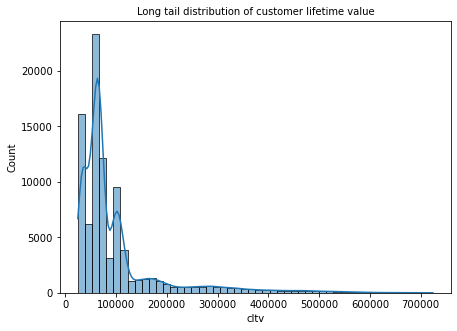

In [13]:
# Output variable distribution
plt.figure(figsize=(7, 5))
sns.histplot(x=df_train['cltv'], bins=50, kde=True)
plt.title("Long tail distribution of customer lifetime value", size=10)
plt.show()

From the above histogram, we can see that, the customer liftetime value has a long tail distribution with outliers. Let's remove the outliers from the data.

In [14]:
# Remove outliers
# Compute the 1st and 3rd quantile.
def remove_outlier(data):
    
    Q1 = np.quantile(data, 0.25)
    Q3 = np.quantile(data, 0.75)

    IQR = Q3 - Q1

    upper_range = Q3 + IQR*1.5
    lower_range = Q1 - IQR*1.5

    data = np.where(data > upper_range, upper_range, data)
    data = np.where(data < lower_range, lower_range, data)
    return data
    
df_train['cltv'] = remove_outlier(df_train['cltv'])

In [15]:
y_train = remove_outlier(y_train)
y_test = remove_outlier(y_test)
y_valid = remove_outlier(y_valid)

## One way ANOVA hypothesis test.

Let's compute the one way anova hypothesis test of correlation for categorical variable and output numeric variable.

- **H0(null hypothesis)**:  The mean of group of each category of given feature variable is same.
- **H1(alternative hypothesis)**: There is difference between these two or more group means.


In [16]:
# ANOVA TEST for - Gender
f_stats, p_value = stats.f_oneway(df_train[df_train['gender'] == 'Female']['cltv'],
                                  df_train[df_train['gender'] == 'Male']['cltv'])

print("ANOVA hypothesis test::")
print("F_statistics::", f_stats)
print("P-value::", p_value)

if p_value < 0.05:
    print(f"p-value={p_value:.3f}, Null hypothesis is rejected")
else:
    print(f"p-value={p_value:.3f} failed to reject null hypothesis.")

ANOVA hypothesis test::
F_statistics:: 29.897994058170294
P-value:: 4.565994041522391e-08
p-value=0.000, Null hypothesis is rejected


The above ANOVA test results has p-value which is less than 0.05, which reject the null hypothesis. This tells us that there is  statistically significant difference in means of gender categories.

In [17]:
# Summary statistics by categories.
a = round(df_train.loc[df_train.gender=='Male', 'cltv'].describe(), 2)
b = round(df_train.loc[df_train.gender=='Female', 'cltv'].describe(), 2)

pd.concat([a, b], keys=['Male', 'Female'], axis=1)

,Male,Female
count,50474.00,38864.00
mean,81852.81,83544.60
std,46335.16,45205.97
min,25848.00,24828.00
25%,50556.00,55656.00
50%,65832.00,67152.00
75%,103200.00,103812.00
max,179364.00,179364.00


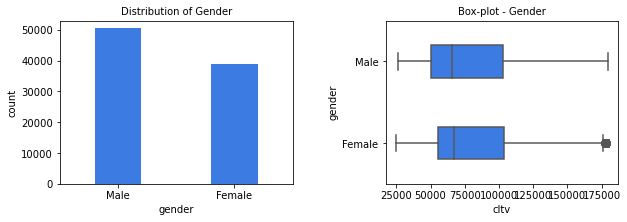

In [18]:
# Distribution of feature `Gender`
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

sns.countplot(data=df_train, x='gender', width=0.4, color='#1f75fe', ax=ax1)
ax1.set_title("Distribution of Gender", size=10)

sns.boxplot(data=df_train, x='cltv', y='gender', width=0.4, color='#1f75fe', ax=ax2)
ax2.set_title("Box-plot - Gender", size=10)
plt.show()

We can see from the above box plot, the distribution of `customer lifetime value` is almost same for both categories male and female.

In [19]:
# ANOVA TEST for - Qualification - 'Bachelor' 'High School' 'Others'
f_stats, p_value = stats.f_oneway(df_train[df_train['qualification'] == 'Bachelor']['cltv'],
                                  df_train[df_train['qualification'] == 'High School']['cltv'],
                                  df_train[df_train['qualification'] == 'Others']['cltv'])

print("ANOVA hypothesis test::")
print("F_statistics::", f_stats)
print("P-value::", p_value)

if p_value < 0.05:
    print(f"p-value={p_value:.3f}, Null hypothesis is rejected")
else:
    print(f"p-value={p_value:.3f}, failed to reject null hypothesis.")

ANOVA hypothesis test::
F_statistics:: 172.90381698580285
P-value:: 1.131847603610698e-75
p-value=0.000, Null hypothesis is rejected


The above `ANOVA` test for qualification feature shows that there is statistical significant difference between means of different education degrees.

In [20]:
# Let's see the distribution of qualification 
bachelor_d = round(df_train.loc[df_train.qualification=='Bachelor', 'cltv'].describe(), 2)
high_school_d = round(df_train.loc[df_train.qualification=='High School', 'cltv'].describe(), 2)
other_d = round(df_train.loc[df_train.qualification=='Others', 'cltv'].describe(), 2)

pd.concat([bachelor_d, high_school_d, other_d], keys=['Bachelor', 'HighSchool', 'Others'], axis=1)

,Bachelor,HighSchool,Others
count,39371.00,46221.00,3746.00
mean,82963.01,83370.40,69011.21
std,45260.59,46549.65,41073.77
min,24876.00,24828.00,27792.00
25%,54720.00,52836.00,36060.00
50%,66876.00,66432.00,60516.00
75%,103644.00,104352.00,72729.00
max,179364.00,179364.00,179364.00


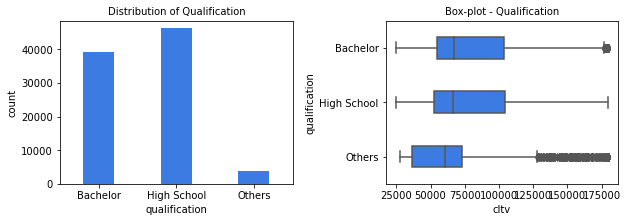

In [21]:
# Distribution of feature `qualification`
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

sns.countplot(data=df_train, x='qualification', width=0.4, color='#1f75fe', ax=ax1)
ax1.set_title("Distribution of Qualification", size=10)

sns.boxplot(data=df_train, x='cltv', y='qualification', width=0.4, color='#1f75fe', ax=ax2)
ax2.set_title("Box-plot - Qualification", size=10)
plt.show()

We can from the above box-plot that, there is no such difference in means of customers with `Bachelor` or `High School` degree. But, there is statistical difference in means of `Others`.

In [22]:
# ANOVA TEST for - Income - ['5L-10L', 'More than 10L', '<=2L', '2L-5L']
f_stats, p_value = stats.f_oneway(df_train[df_train['income'] == '5L-10L']['cltv'],
                                  df_train[df_train['income'] == 'More than 10L']['cltv'],
                                  df_train[df_train['income'] == '<=2L']['cltv'],
                                  df_train[df_train['income'] == '2L-5L']['cltv']
                                 )

print("ANOVA hypothesis test::")
print("F_statistics::", f_stats)
print("P-value::", p_value)

if p_value < 0.05:
    print(f"p-value={p_value:.3f}, Null hypothesis is rejected")
else:
    print(f"p-value={p_value:.3f}, failed to reject null hypothesis.")

ANOVA hypothesis test::
F_statistics:: 280.1473748130343
P-value:: 5.201291529826173e-181
p-value=0.000, Null hypothesis is rejected


The above `ANOVA` test for income feature shows that there is statistical significant difference in means of customer lifetime value(cltv) of different income cateogries of customers.

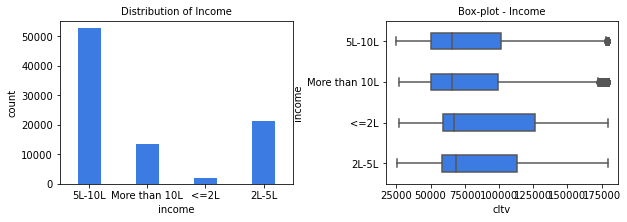

In [23]:
# Distribution of feature `Income`
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

sns.countplot(data=df_train, x='income', width=0.4, color='#1f75fe', ax=ax1)
ax1.set_title("Distribution of Income", size=10)

sns.boxplot(data=df_train, x='cltv', y='income', width=0.4, color='#1f75fe', ax=ax2)
ax2.set_title("Box-plot - Income", size=10)
plt.show()

The above `ANOVA` test and box plot distribution shows that, there is significant differences in means of income ranges of customer with customer lifetime value.

In [24]:
# ANOVA TEST for - Martial Status 0 - single 1- married.
f_stats, p_value = stats.f_oneway(df_train[df_train['marital_status'] == 0]['cltv'],
                                  df_train[df_train['marital_status'] == 1]['cltv'])

print("ANOVA hypothesis test::")
print("F_statistics::", f_stats)
print("P-value::", p_value)

if p_value < 0.05:
    print(f"p-value={p_value:.3f}, Null hypothesis is rejected")
else:
    print(f"p-value={p_value:.3f} failed to reject null hypothesis.")

ANOVA hypothesis test::
F_statistics:: 803.2561861584604
P-value:: 6.390653554446461e-176
p-value=0.000, Null hypothesis is rejected


The above `ANOVA` test results has p-value which is less than 0.05, which reject the null hypothesis. This tells us that there is statistically significant difference in means of marital status of customers.

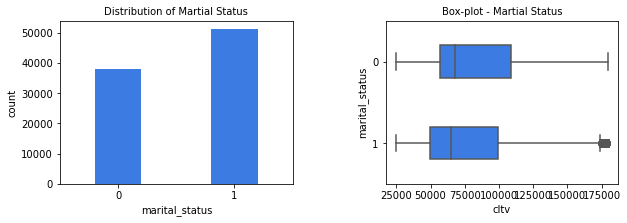

In [25]:
# Distribution of feature `Income`
a = df_train['marital_status'].astype('category')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

sns.countplot(data=df_train, x=a, width=0.4, color='#1f75fe', ax=ax1)
ax1.set_title("Distribution of Martial Status", size=10)

sns.boxplot(data=df_train, x='cltv', y=a, width=0.4, color='#1f75fe', ax=ax2)
ax2.set_title("Box-plot - Martial Status", size=10)
plt.show()

In [26]:
# ANOVA TEST for - Area
f_stats, p_value = stats.f_oneway(df_train[df_train['area'] == 'Urban']['cltv'],
                                  df_train[df_train['area'] == 'Rural']['cltv'])

print("ANOVA hypothesis test::")
print("F_statistics::", f_stats)
print("P-value::", p_value)

if p_value < 0.05:
    print(f"p-value={p_value:.3f}, Null hypothesis is rejected")
else:
    print(f"p-value={p_value:.3f} failed to reject null hypothesis.")

ANOVA hypothesis test::
F_statistics:: 2062.5046609252254
P-value:: 0.0
p-value=0.000, Null hypothesis is rejected


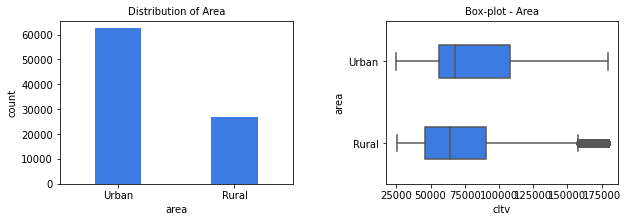

In [27]:
# Distribution of feature `area`
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

sns.countplot(data=df_train, x='area', width=0.4, color='#1f75fe', ax=ax1)
ax1.set_title("Distribution of Area", size=10)

sns.boxplot(data=df_train, x='cltv', y='area', width=0.4, color='#1f75fe', ax=ax2)
ax2.set_title("Box-plot - Area", size=10)
plt.show()

The above `ANOVA` test and box plot distribution shows that, there is significant differences in means of type of area.

In [28]:
# ANOVA TEST for - vintage - [0, 1, 2, 3, 4, 5, 6, 7, 8]
f_stats, p_value = stats.f_oneway(df_train[df_train['vintage'] == 0]['cltv'],
                                  df_train[df_train['vintage'] == 1]['cltv'],
                                  df_train[df_train['vintage'] == 2]['cltv'],
                                  df_train[df_train['vintage'] == 3]['cltv'],
                                  df_train[df_train['vintage'] == 4]['cltv'],
                                  df_train[df_train['vintage'] == 5]['cltv'],
                                  df_train[df_train['vintage'] == 6]['cltv'],
                                  df_train[df_train['vintage'] == 7]['cltv'],
                                  df_train[df_train['vintage'] == 8]['cltv'])

print("ANOVA hypothesis test::")
print("F_statistics::", f_stats)
print("P-value::", p_value)

if p_value < 0.05:
    print(f"p-value={p_value:.3f}, Null hypothesis is rejected")
else:
    print(f"p-value={p_value:.3f}, failed to reject null hypothesis.")

ANOVA hypothesis test::
F_statistics:: 39.489589899591806
P-value:: 2.1967698676650302e-63
p-value=0.000, Null hypothesis is rejected


In [29]:
# ANOVA TEST for - Type of policy - ['Platinum', 'Gold', 'Silver']
f_stats, p_value = stats.f_oneway(df_train[df_train['type_of_policy'] == 'Platinum']['cltv'],
                                  df_train[df_train['type_of_policy'] == 'Gold']['cltv'],
                                  df_train[df_train['type_of_policy'] == 'Silver']['cltv']
                                 )
print("ANOVA hypothesis test::")
print("F_statistics::", f_stats)
print("P-value::", p_value)

if p_value < 0.05:
    print(f"p-value={p_value:.3f}, Null hypothesis is rejected")
else:
    print(f"p-value={p_value:.3f}, failed to reject null hypothesis.")

ANOVA hypothesis test::
F_statistics:: 85.56223640713438
P-value:: 7.522070474002407e-38
p-value=0.000, Null hypothesis is rejected


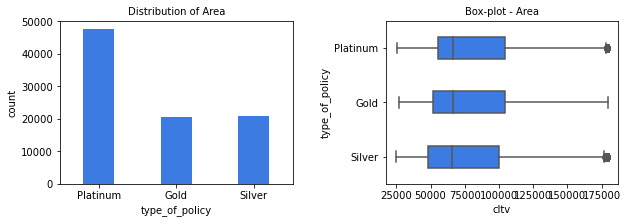

In [30]:
# Distribution of feature `Type of policy`
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

sns.countplot(data=df_train, x='type_of_policy', width=0.4, color='#1f75fe', ax=ax1)
ax1.set_title("Distribution of Area", size=10)

sns.boxplot(data=df_train, x='cltv', y='type_of_policy', width=0.4, color='#1f75fe', ax=ax2)
ax2.set_title("Box-plot - Area", size=10)
plt.show()

From `ANOVA` and box plot we can say that, there is slight difference in means of types of policy of customers.

### Correlation analysis - Numeric Variable

In [31]:
# Distribution of numerical features
X_train['claim_amount'].describe()

count    89338.000000
mean      4352.843393
std       3262.251793
min          0.000000
25%       2407.000000
50%       4089.000000
75%       6094.000000
max      31894.000000
Name: claim_amount, dtype: float64

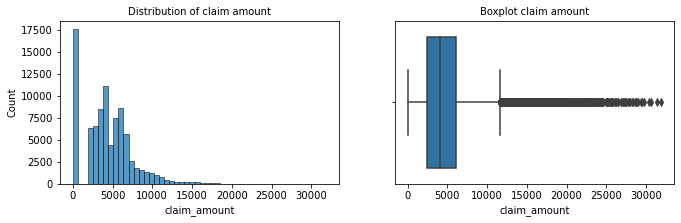

In [32]:
# Histogram plot for distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

sns.histplot(data=X_train, x='claim_amount', bins=50, ax=ax1)
ax1.set_title("Distribution of claim amount", size=10)

sns.boxplot(x=X_train['claim_amount'], orient='h', ax=ax2)
ax2.set_title("Boxplot claim amount", size=10)

plt.show()

We can see that, the distribution of claim_amount data is highly right skewed, there are lots of outlier present in data.

In [33]:
# Correlation between features and target variable
df_train.corr()['cltv']

marital_status   -0.094400
vintage           0.030781
claim_amount      0.207082
cltv              1.000000
Name: cltv, dtype: float64

# Data preprocessing

In [34]:
# Perform a log transformation on numeric data to make distritubtion normal.
# Output variable
y_train = np.log1p(y_train)
y_valid = np.log1p(y_valid)
y_test = np.log1p(y_test)

# input variable
X_train['claim_amount'] = np.log1p(X_train['claim_amount'])
X_valid['claim_amount'] = np.log1p(X_valid['claim_amount'])
X_test['claim_amount'] = np.log1p(X_test['claim_amount'])

In [35]:
# Replace the 'Other' values in qualification with model value
val = X_train['qualification'].mode()[0]
X_train['qualification'] = X_train['qualification'].replace({'Others':val})
X_test['qualification'] = X_test['qualification'].replace({'Others':val})
X_valid['qualification'] = X_valid['qualification'].replace({'Others':val})

In [36]:
from sklearn.feature_extraction import DictVectorizer

# convert dataframe into dictionary
train_dict = X_train.to_dict(orient='records')
valid_dict = X_valid.to_dict(orient='records')
test_dict = X_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dict)
x_valid = dv.transform(valid_dict)
x_test  = dv.transform(test_dict)

In [37]:
# Standarization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train__transform = scaler.fit_transform(x_train)
X_valid__transform = scaler.transform(x_valid)
X_test__transform = scaler.transform(x_test)

In [38]:
# Base Model
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train__transform, y_train)

y_preds = lr_model.predict(X_valid__transform)
score = r2_score(y_valid, y_preds)
print("Test r2 score:: ", score)

Test r2 score::  0.47546248878832253


In [39]:
y_preds = lr_model.predict(X_train__transform)
score = r2_score(y_train, y_preds)
print("Train r2 score:: ", score)

Train r2 score::  0.37622598515825134


In [40]:
y_preds = lr_model.predict(X_test__transform)
score = r2_score(y_test, y_preds)
print("Train r2 score:: ", score)

Train r2 score::  0.11088302216395307


In [41]:
# Spot check multiple regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score

models = {
    "LR":LinearRegression(),
    "AB":AdaBoostRegressor(random_state=42),
    "RF":RandomForestRegressor(random_state=42),
    "GB":GradientBoostingRegressor(max_depth=None, random_state=42),
    "XGB":XGBRegressor(random_state=42)
}

for name, reg in models.items():
    score = cross_val_score(reg, X_train__transform, y_train, scoring='r2', cv=7)
    print("%s: score:: %.3f +-(%.3f)" % (name, np.mean(score), np.std(score)))   

/srv/conda/envs/saturn/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


LR: score:: 0.376 +-(0.008)
AB: score:: 0.367 +-(0.009)
RF: score:: 0.300 +-(0.011)
GB: score:: -0.162 +-(0.021)
XGB: score:: 0.377 +-(0.008)


In [42]:
# n_estimators
scores = []
for n in range(100, 600, 100):
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    score = cross_val_score(model, X_train__transform, y_train, scoring='r2', cv=3)
    scores.append((n, np.mean(score), np.std(score)))

In [43]:
pd.DataFrame(scores, columns=['n_estimators', 'r2-score', 'std']).sort_values(by=['r2-score'], ascending=False).head()

,n_estimators,r2-score,std
4,500,0.306715,0.005781
3,400,0.306545,0.005719
2,300,0.306178,0.005422
1,200,0.305215,0.005736
0,100,0.302308,0.006027


In [44]:
# max-depth
scores = []
for n in range(100, 600, 100):
    for depth in [2, 3, 5, 7, 9]:
        model = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=42)
        score = cross_val_score(model, X_train__transform, y_train, scoring='r2', cv=3)
        scores.append((n, depth, np.mean(score), np.std(score)))
        
pd.DataFrame(scores, columns=['n_estimators', 'max-depth', 'r2-score', 'std']).sort_values(by=['r2-score'], ascending=False).head()

,n_estimators,max-depth,r2-score,std
23,500,7,0.387448,0.005180
13,300,7,0.387446,0.005140
8,200,7,0.387443,0.005133
18,400,7,0.387441,0.005184
3,100,7,0.387329,0.005116


In [45]:
# final model
model = RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42)

# fitting data
model.fit(X_train__transform, y_train)

# Predictions
y_preds = model.predict(X_train__transform)
print("Train score::", r2_score(y_train, y_preds))

y_preds = model.predict(X_valid__transform) 
print("Test score::", r2_score(y_valid, y_preds))

Train score:: 0.39508137402038557
Test score:: 0.5173535002139202


In [46]:
y_preds = model.predict(X_test__transform)
print("Test score::", r2_score(y_test, y_preds))

Test score:: 0.1439245488317693


# Test Data

In [47]:
test_df = pd.read_csv("./test_koRSKBP.csv", index_col='id')

In [48]:
test_df['claim_amount'] = np.log1p(test_df['claim_amount'])
test_df['qualification'] = test_df['qualification'].replace({'Others':val})

In [49]:
test_df_dict = test_df.to_dict(orient='records')
test_transform = dv.transform(test_df_dict)
test_transform = scaler.transform(test_transform)

In [50]:
predictions = model.predict(test_transform)
cltv = np.expm1(predictions)
solution = pd.Series(cltv, index=test_df.index, name='cltv')
solution

id
89393     77486.224003
89394     92552.351451
89395     77307.169380
89396     75942.097362
89397     98255.549185
              ...     
148983    43155.979743
148984    42596.428853
148985    81339.582954
148986    83725.098783
148987    89415.834640
Name: cltv, Length: 59595, dtype: float64

In [52]:
solution.to_csv(".solution.csv")